# Loading & Preprocessing

In [0]:
from google.colab import drive
drive.mount('/content/drive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!git clone https://github.com/abhinavsagar/breast.git

Cloning into 'breast'...
remote: Enumerating objects: 1198, done.
remote: Counting objects: 100% (1198/1198), done.
remote: Compressing objects: 100% (1196/1196), done.
remote: Total 1198 (delta 1), reused 1192 (delta 0), pack-reused 0
Receiving objects: 100% (1198/1198), 569.51 MiB | 15.31 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (1186/1186), done.


In [0]:
%cd breast

/content/breast/breast


In [17]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


%matplotlib inline

In [18]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB")) ## Lambda Function to read image and convert it to RGB
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)  ## Generate path for each image in a folder
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('data/train/benign',224))
malign_train = np.array(Dataset_loader('data/train/malign',224))
# benign_test = np.array(Dataset_loader('data/validation/benign',224))
# malign_test = np.array(Dataset_loader('data/validation/malignant',224))

100%|██████████████████████████████████████████████████████████████████████████████| 1138/1138 [00:54<00:00, 19.47it/s]


# Create Label

In [19]:
# Skin Cancer: Malignant vs. Benign
# Create labels
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
# benign_test_label = np.zeros(len(benign_test))
# malign_test_label = np.ones(len(malign_test))

# Merge data 
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
# X_test = np.concatenate((benign_test, malign_test), axis = 0)
# Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
# s = np.arange(X_test.shape[0])
# np.random.shuffle(s)
# X_test = X_test[s]
# Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
# Y_test = to_categorical(Y_test, num_classes= 2)

In [20]:
y = np.array([1,0,1,1,1,0,0,0])
y_cat = to_categorical(y,num_classes=2)
print(y_cat)

[[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


# Train and Evalutation split

In [21]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

# Display Some Images

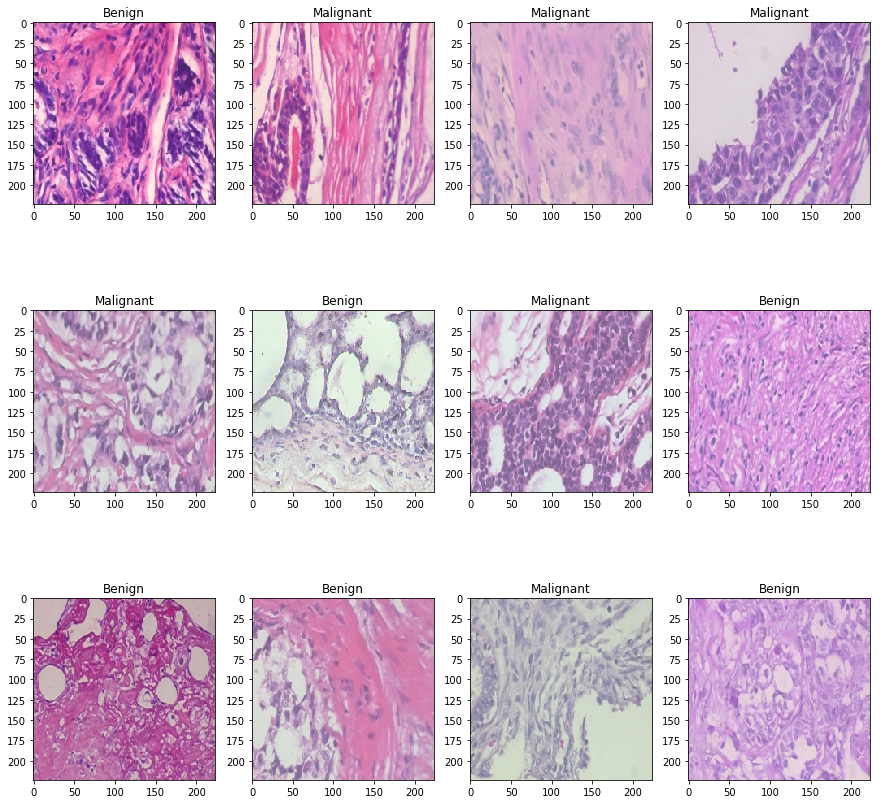

In [22]:

# # Display first 15 images of moles, and how they are classified
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

# Data Generator

In [12]:
BATCH_SIZE = 16

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

# Model: ResNet50

In [13]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

In [14]:
K.clear_session()
gc.collect()

resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)


 


model = build_model(resnet ,lr = 1e-4)
model.summary()

74842112/74836368 [==============================] - ETA: 16:0 - ETA: 10:0 - ETA: 6:0 - ETA: 8: - ETA: 12:4 - ETA: 15:2 - ETA: 19:3 - ETA: 18:1 - ETA: 15:0 - ETA: 12:3 - ETA: 14:4 - ETA: 16:5 - ETA: 18:0 - ETA: 17:5 - ETA: 13:0 - ETA: 11:0 - ETA: 10:4 - ETA: 11:1 - ETA: 11:5 - ETA: 12:0 - ETA: 12:2 - ETA: 12:2 - ETA: 12:4 - ETA: 12:3 - ETA: 12:3 - ETA: 12:3 - ETA: 10:4 - ETA: 9:5 - ETA: 10:0 - ETA: 9:5 - ETA: 9: - ETA: 8: - ETA: 7: - ETA: 7: - ETA: 6: - ETA: 6: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ET

In [15]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Training & Evaluation

In [ ]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/20
46/87 [==============>...............] - ETA: 4:29:53 - loss: 1.0738 - acc: 0.56 - ETA: 3:08:04 - loss: 0.9372 - acc: 0.59 - ETA: 2:34:22 - loss: 0.9744 - acc: 0.56 - ETA: 2:16:29 - loss: 0.8885 - acc: 0.60 - ETA: 2:05:06 - loss: 0.9208 - acc: 0.58 - ETA: 1:56:58 - loss: 0.8888 - acc: 0.60 - ETA: 1:50:52 - loss: 0.8393 - acc: 0.62 - ETA: 1:46:02 - loss: 0.8111 - acc: 0.63 - ETA: 1:42:03 - loss: 0.7861 - acc: 0.62 - ETA: 1:38:36 - loss: 0.8036 - acc: 0.60 - ETA: 1:35:44 - loss: 0.7691 - acc: 0.62 - ETA: 1:33:11 - loss: 0.7815 - acc: 0.62 - ETA: 1:30:49 - loss: 0.7984 - acc: 0.62 - ETA: 1:28:38 - loss: 0.7674 - acc: 0.62 - ETA: 1:26:36 - loss: 0.7634 - acc: 0.62 - ETA: 1:24:35 - loss: 0.7415 - acc: 0.64 - ETA: 1:22:41 - loss: 0.7466 - acc: 0.64 - ETA: 1:20:57 - loss: 0.7388 - acc: 0.64 - ETA: 1:19:16 - loss: 0.7213 - acc: 0.65 - ETA: 1:17:39 - loss: 0.7006 - acc: 0.66 - ETA: 1:16:03 - loss: 0.7164 - acc: 0.66 - ETA: 1:14:32 - loss: 0.7121 - acc: 0.66 - ETA: 1:13:03 - loss: 0.7

In [0]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

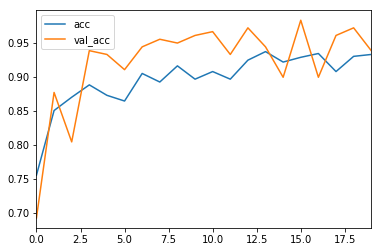

In [0]:
history_df = pd.DataFrame(history.history)
history_df[['acc', 'val_acc']].plot()

In [0]:
from google.colab import drive
drive.mount('/content/drive')

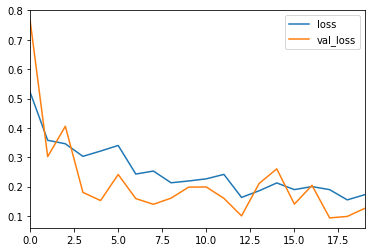

In [0]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

# Prediction

In [0]:
model.load_weights("weights.best.hdf5")

In [0]:
Y_val_pred = model.predict(x_val)

In [0]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

0.9832402234636871

In [0]:
Y_pred = model.predict(X_test)

In [0]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

100%|██████████| 10/10 [01:09<00:00,  6.79s/it]


### Confusion Matrix

Confusion matrix, without normalization
[[ 60  77]
 [ 10 140]]


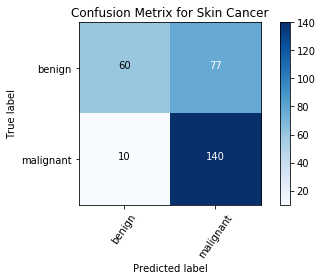

In [0]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

Confusion matrix, without normalization
[[ 59  78]
 [  7 143]]


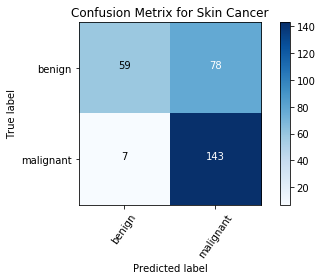

In [0]:
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

### Classification Report

In [0]:
from sklearn.metrics import classification_report
classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

'              precision    recall  f1-score   support\n\n           0       0.89      0.43      0.58       137\n           1       0.65      0.95      0.77       150\n\n    accuracy                           0.70       287\n   macro avg       0.77      0.69      0.68       287\nweighted avg       0.76      0.70      0.68       287\n'

### ROC and AUC

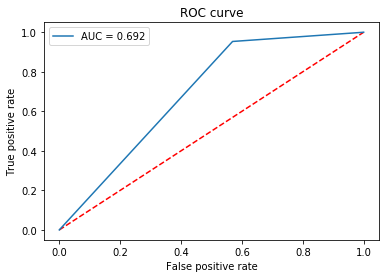

In [0]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

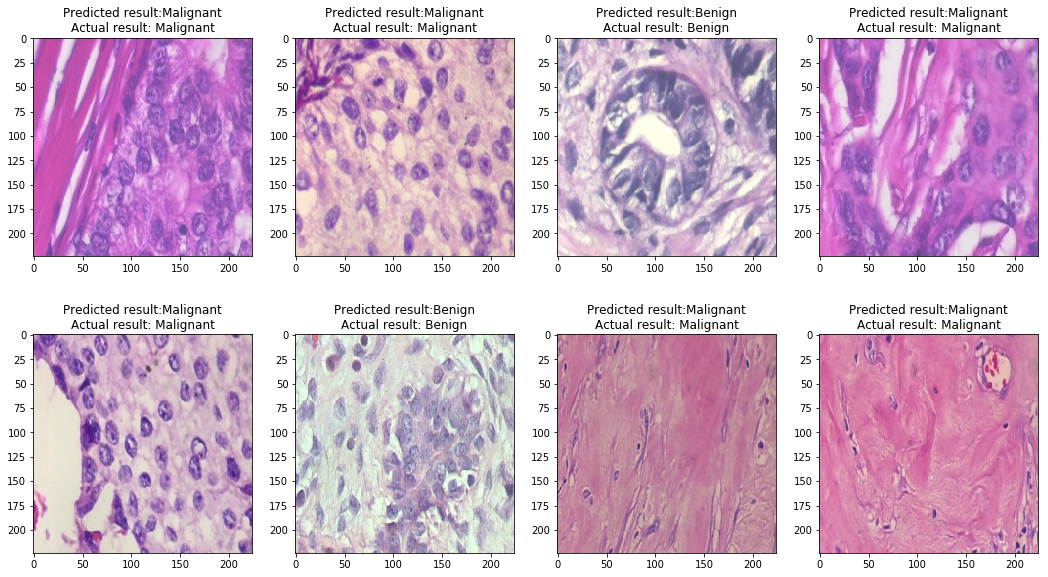

In [0]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Display first 8 images of benign
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()